In [16]:
"""
This is an attempt to implement machine learning to solve an inverse DTMM problem
(determinining the director structure based on an a set of input microscope images),
much like the prevoius example, just that here we only examine one pixel instead of
a larger area. In the prevous example, the director structure was given by an analytic 
expression as a function of some parameters (like A*sin(Bx)), in this case, however,
it is given by a full configuration of phi (in plane) and theta (perpendicular) angles
through individual layers for one pixel.

The images are simulated using the dtmm library and the configurations
are generated as a random grid with interpolated values in between.

It is shown that the concept works relatively well, but some additional adjustments
might be beneficial.
Generating more data would also be very good, but it takes quite a lot of time.

For anyone reading this file, it may be helful to look at the other 
dtmm machine learning file first, beacuse some things might be better explained there.

To do:
- Consider using a Q tensor or (x,y) + loss: x**2 + y**2 - 1 instead of (phi, theta)
- Implement off-axis simulations in dtmm to try random thetas as well
- Try only predicting the grid values and interpolating everything in between.
  I have started that but it should still see some corrections and much more training data. See file "ML_DTMM_1pixel_grid_only"
- Try not predicting the alignment layers as they can be known from the experiment.
  Quick solution is to specify only one alignment option in the custom loss function.
  Otherwise: delete the discrete term in loss function and adjust the continuity term
  to include fixed (not fitted) alignment layers as well and activate this term at at epoch 0
  (but only for the layers close to the alignment layers).

Written by Simon.
"""

'\nThis is an attempt to implement machine learning to solve an inverse DTMM problem\n(determinining the director structure based on an a set of input microscope images),\nmuch like the prevoius example, just that here we only examine one pixel instead of\na larger area. In the prevous example, the director structure was given by an analytic \nexpression as a function of some parameters (like A*sin(Bx)), in this case, however,\nit is given by a full configuration of phi (in plane) and theta (perpendicular) angles\nthrough individual layers for one pixel.\n\nThe images are simulated using the dtmm library and the configurations\nare generated as a random grid with interpolated values in between.\n\nIt is shown that the concept works relatively well, but some additional adjustments\nmight be beneficial.\nGenerating more data would also be very good, but it takes quite a lot of time.\n\nFor anyone reading this file, it may be helful to look at the other \ndtmm machine learning file first,

In [3]:
# IMPORTS AND INITIAL SETTINGS:
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from dtmm.conf import CDTYPE, FDTYPE
import dtmm
import matplotlib
from tqdm import tqdm
import itertools
import time
import glob
import tensorflow as tf
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib import cm
from matplotlib.colors import Normalize
import datetime

# timestamp:
timestamp = str(datetime.datetime.now()).replace(":", ".")[:-10]

plt.rcParams.update({"figure.dpi":150,
                     "axes.grid":True,
                     "grid.color": "grey",
                     "grid.linestyle": ":",
                    'figure.figsize' : [4, 8]
                    })
# folders:
FILENAME = "40000_10"
SAVEFOLDER= "D:\\Users Data\\Simon\\MachineLearning\\saved_data\\"

In [4]:
# INITIAL GLOBAL INPUTS:
"""
Input the parameters needed globally for configurations generations etc.
"""

N_GRID_LAYERS = 6
N_ADD_BETWEEN = 5 # how many to add in each "void" between grid values 
N_ALL_LAYERS = (N_GRID_LAYERS - 1) * N_ADD_BETWEEN + N_GRID_LAYERS
N_GRID_MID = N_GRID_LAYERS - 2 # minus alignment

THICKNESS = 3.1 # in microns
WAVELENGTHS = np.linspace(380,780,11) # nm

PIXX, PIXY = 1, 1 # number of pixels
PIXELSIZE = 365 # in nm
WIDTH = PIXX * PIXELSIZE / 1000 # microns
HEIGHT = PIXY * PIXELSIZE / 1000 #40. # microns

SHAPE = (N_ALL_LAYERS, PIXY, PIXX) # 1 pix

# material params:
# we use numpy broadcasting rules here, so we add two empty axes to match the angles array shape
EPSILONS = np.zeros((N_ALL_LAYERS, PIXY, PIXX, 3)) # shape0 = N layers (N + 1 ..?)
EPSILONS[...,0] = 1.52**2 # izredni
EPSILONS[...,1] = 1.52**2 # izredni
EPSILONS[...,2] = 1.765**2 # redni


# GLOBAL CALCULATED ARRAYS:
z_layers = np.linspace(-THICKNESS/2,THICKNESS/2, N_ALL_LAYERS) # all values of z at all layers
z_grid = np.linspace(-THICKNESS/2, THICKNESS/2, N_GRID_LAYERS) # all values of z at grid layers

# range of coordinates in z,y, and x directions
z = z_layers
y = np.linspace(0, HEIGHT, PIXY)
x = np.linspace(0, WIDTH, PIXX)

# we use ij indexing in dtmm, the first axis is (i = z), then height (j = y), then width (k = x)
zzz,yyy,xxx = np.meshgrid(z,y,x, indexing = 'ij') # this meshgrid is only used for angles conversion to dtmm shape - not sure if necessary. Can be replaced with the faster solution.

In [5]:
# FUNCTION DEFINITIONS
def generate_random_configuration(top_phi, bottom_phi, top_theta, bottom_theta, random_theta=False):
    """
    Generate random angular configurations (phi, theta, psi) for a given grid of layers.

    Psi remains zero for all layers - for now.
    
    Theta is either randomized or constant. In case it is constant, but the
    alignment layers for top and bottom theta are different,
    all thetas in between are interpolaetd.

    Parameters:
    -----------
    top_phi : float. The angle phi (rad) at the top alignment layer.
    bottom_phi : float. The angle phi (rad) at the bottom alignment layer.
    top_theta : float. The angle theta (rad) at the top alignment layer.
    bottom_theta : float. The angle theta (rad) at the bottom alignment layer.
    random_theta : bool, optional.
        If True, generate random values for theta between the top and bottom boundaries. 
        If False, interpolate theta linearly between the boundary conditions. Default is False.

    Returns:
    --------
    phi_all : numpy.ndarray. Array of angles phi for all layers.
    theta_all : numpy.ndarray. Array of angles theta for all layers.
    psi_all : numpy.ndarray. Array of rotation angles psi around the optical axis, set to zero for all layers.

    """
    # phi:
    phi_grid_mid = np.random.random(size=N_GRID_MID) * np.pi # not 2pi because n=-n
    phi_grid = np.concatenate(([top_phi], phi_grid_mid, [bottom_phi]))
    phi_interp = CubicSpline(z_grid, phi_grid)
    phi_all = phi_interp(z_layers)

    # theta:
    if random_theta:
        theta_grid_mid = np.random.random(size=N_GRID_MID) * np.pi # not 2pi because n=-n
        theta_grid = np.concatenate(([top_theta], theta_grid_mid, [bottom_theta]))
        theta_interp = CubicSpline(z_grid, theta_grid)
        theta_all = theta_interp(z_layers)
        
    else:
        theta_interp = CubicSpline([z_grid[0], z_grid[-1]], [bottom_theta, top_theta])
        theta_all = theta_interp(z_layers)

    # conversion to x,y,z:
    x_all, y_all, z_all = np.sin(theta_all) * np.cos(phi_all), np.sin(theta_all) * np.sin(phi_all), np.cos(theta_all)
    # x, y, z all are coordinates of one boundary of each director if the first boundary is in (0,0,0).   
    
    psi_all = np.zeros(len(phi_all)) # rotation around the optical axis doesnt make much sense in uniaxial materials
    return phi_all, theta_all, psi_all


def angles_to_xyz(phi_array, theta_array):
    """
    Convert spherical angles (phi, theta) to Cartesian coordinates (x, y, z).
    
    The dtmm library requires angles rather than coordinates for its computations, so
    the conversion is only useful for plotting purposes,
    where visualizing the orientation of elements in 3D space is required.
    
    The output coordinates represent one boundary of each director if the first boundary 
    is assumed to be at the origin (0, 0, 0).

    Parameters:
    -----------
    phi_array : numpy.ndarray
        Array of angles phi in radians.
    theta_array : numpy.ndarray
        Array of  angles theta in radians.

    Returns:
    --------
    x_all : numpy.ndarray. Array of x-coordinates corresponding to the input angles.
    y_all : numpy.ndarray. Array of y-coordinates corresponding to the input angles.
    z_all : numpy.ndarray. Array of z-coordinates corresponding to the input angles.

    """
    
    # conversion to x,y,z:
    x_all, y_all, z_all = np.sin(theta_array) * np.cos(phi_array), np.sin(theta_array) * np.sin(phi_array), np.cos(theta_array)
    
    # x, y, z all are coordinates of one boundary of each director if the first boundary is in (0,0,0).
    return x_all, y_all, z_all


def visualize_config_3D(z_layers, z_grid, x_all, y_all, z_all, fig=None, ax=None, title=None):
    """
    Visualize the 3D configuration of director orientations across a grid of layers.
    
    All directors are represented as line segments, centered around the (0, 0, z) point.
    
   The plot includes three types of points:
      1. Alignment layers (first and last layers in `z_grid`), shown in 'firebrick'.
      2. Inner random grid points, shown in 'darkslategrey'.
      3. Interpolated points between grid points, shown in 'slategrey'.
   A dashed vertical line is drawn to represent the entire z-axis range.
   
   The function can either use an existing figure and axis for plotting or create 
      new ones if none are provided.

    Parameters:
    -----------
    z_layers : numpy.ndarray. Array of z-coordinates for each layer.
    z_grid : numpy.ndarray. Array of z-coordinates for the grid points, including alignment layers and inner grid points.
    x_all : numpy.ndarray. Array of x-coordinates representing the director orientation at each layer.
    y_all : numpy.ndarray. Array of y-coordinates representing the director orientation at each layer.
    z_all : numpy.ndarray. Array of z-coordinates representing the director orientation at each layer.
    fig : matplotlib.figure.Figure, optional
        An existing Matplotlib figure object to plot on. If not provided, a new figure 
        is created. Used for one specific case when plotting results. Default is None.
    ax : matplotlib.axes._subplots.Axes3DSubplot, optional
        An existing 3D axis object to plot on. If not provided, a new axis is created.
        Used for one specific case when plotting results.
        Default is None.
    title : str, optional. Title of the plot. If not provided, a default title "Director configuration 1 pixel" is used.

    Returns: None
    """
    flag=False
    if ax==None:
        flag=True
        fig = plt.figure(figsize=(4,8))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_box_aspect((10,10,30))
    l0, l1, l2 = 0, 0, 0 # to ensure only once in legend
    
    ax.plot([0,0],[0,0],[z_grid[0], z_grid[-1]], color="black", linestyle="--", linewidth=1, alpha=0.5) # vertical line
    
    for i, za in enumerate(z_layers):
        x = [- x_all[i]/2, x_all[i]/2] 
        y = [- y_all[i]/2, y_all[i]/2]
        z = [z_layers[i] - z_all[i]/2, z_layers[i] + z_all[i]/2]
        
        if np.any(np.isclose(z_grid, za, atol=0.001)): # if grid points + tolerance
            if za == z_grid[0] or za == z_grid[-1]: # alignment layer
                if l0 == 0:
                    ax.plot(x, y, z, color='firebrick', marker='o', label="Alignment layer")
                    l0 = 1
                else:
                    ax.plot(x, y, z, color='firebrick', marker='o')
            else:
                if l1 == 0:
                    ax.plot(x, y, z, color='darkslategrey', marker='o', label="Inner random grid")
                    l1 = 1
                else:
                    ax.plot(x, y, z, color='darkslategrey', marker='o') 
                    
        else: # interpolated points
            if l2 == 0:
                ax.plot(x, y, z, color='slategrey', marker='o', label="Interpolated") 
                l2 = 1
            else:
                ax.plot(x, y, z, color='slategrey', marker='o') 
       
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    if title:
        ax.set_title(title)
    else:
        ax.set_title("Director configuration 1 pixel")
    plt.legend(loc="lower left")
    
    if flag:
        plt.show()


def reshape_angles_dtmm(phi_array, theta_array, psi_array):
    """
    This function reformats the provided spherical angles (phi, theta, psi) into a 3D array 
    structure that is compatible with the dtmm library. The resulting array has a shape of 
    `(Nlayers, PIXY, PIXY, 3)`, where the last dimension stores the angles in the order 
    `[psi, theta, phi]`.
    
    The implemented solution matches the "historical" one for more than 1*1pixel,
    but an alternative is presented as well.
    
    Parameters:
    -----------
    phi_array : numpy.ndarray. Array of angles phi to be reshaped.
    theta_array : numpy.ndarray. Array of angles theta to be reshaped.
    psi_array : numpy.ndarray. Array of rotation angles (psi) around the optical axis to be reshaped.
    Returns:
    --------
    angles : numpy.ndarray. A 3D array of shape `(Nlayers, PIXY, PIXY, 3)`, where the last dimension contains 
        the angles `[psi, theta, phi]`.
    """
    # direct solution:
    #angles = np.column_stack(psi_array, theta_array, phi_array).reshape((SHAPE+(3,))) 
    
    # solution to match the existing one (for future compatibility ...?):
    # reshape to (Nlayers, PIXY, PIXY)
    phi_array = phi_array.reshape((SHAPE))
    theta_array = theta_array.reshape((SHAPE))
    psi_array = psi_array.reshape((SHAPE))
    
    # empty array:
    angles = np.empty(SHAPE+(3,), dtype = FDTYPE)
 
    # fill the array
    angles[...,0] = psi_array
    angles[...,1] = theta_array
    angles[...,2] = phi_array

    return angles
    

def calculate_field_1pixel(angles, epsilons, ds):
    """
    This function computes the optical field for a single pixel based on the provided angular 
    orientations, permittivity tensor components, and layer thicknesses. The calculation 
    leverages the `dtmm` library's field transfer capabilities.

    Parameters:
    -----------
    angles : numpy.ndarray. A 3D array of angular orientations (psi, theta, phi) for each layer in the pixel.
    epsilons : numpy.ndarray. A 3D array of permittivity tensors for each layer in the pixel.
    ds : numpy.ndarray. An array of thicknesses for each layer in the pixel.

    Returns:
    --------
    field_data_out : numpy.ndarray. The resulting optical field data after propagation through the pixel.
    """
    optical_block = ds, epsilons, angles
    
    #pixelsize = THICKNESS/N_ALL_LAYERS * 1000
    
    field_data_in = dtmm.illumination_data((PIXY, PIXX), WAVELENGTHS, pixelsize = PIXELSIZE , diffraction = False)
    field_data_out = dtmm.transfer_field(field_data_in, [optical_block], diffraction = 0, split_wavelengths=False)
    
    return field_data_out
    

def calculate_images_1pixel(angles, epsilons, ds, intensity, exp_config):
    """
    Calculate RGB images for a single pixel configuration under various experimental settings.
    
    Parameters:
    -----------
    angles : numpy.ndarray. A 3D array of angular orientations (psi, theta, phi) for each layer in the pixel.       
    epsilons : numpy.ndarray. A 3D array of permittivity tensors for each layer in the pixel.
    ds : numpy.ndarray. An array of thicknesses for each layer in the pixel.     
    intensity : float. The intensity of the light used in the image calculation.
    exp_config : list of tuples.
        A list of experimental configurations, where each tuple contains:
        - `p`: polarizer angle or setting.
        - `a`: analyzer angle or setting.
        - `r`: retarder (lambda plate) setting.

    Returns:
    --------
    images : numpy.ndarray. An array of RGB images, with shape `(len(exp_config), PIXY, PIXX, 3)`, where each image 
        corresponds to a specific experimental configuration.
    """
    field_out = calculate_field_1pixel(angles, epsilons, ds)

    cmf = dtmm.color.load_tcmf(WAVELENGTHS, illuminant = "A")
    viewer = dtmm.field_viewer(field_out, diffraction = False, cmf = cmf)
    images = np.empty((len(exp_config), PIXY, PIXX, 3))
    
    i=-1
    # iterate through all experimental configurations (polarizers, lambda plates ...)
    for p, a, r in exp_config:
        i += 1
        viewer.set_parameters(polarizer = p, analyzer = a, intensity = intensity, retarder = r)
        # dodaj še offaxis
        im = viewer.calculate_image() # np array
        images[i] = im
    return images 


def generate_configurations(alignment_configurations, n_rep, n_all_layers, theta=False):
    """
    Generate an array of random director configurations, based on "generate_random_configuration"
    function. The output array is later coupled with intensity/dfactor pairs array to create
    learning labels.
    
    Parameters:
    -----------
    alignment_configurations: An array of all possible combinations of alignment layers phi and theta,
                              where each element is composed as (top_phi, bottom_phi, top_theta, bottom_theta).
    n_rep: int. Number of random configurations for each alignment configurations.
    n_all_layers: int. Number of all layers.
    theta: bool. Flag to indicate wether to generate random thetas, based on
                "generate_random_configuration"'s "random_theta" flag.
                
    Returns:
    --------
    conf_arr: numpy.ndarray. An array of all configurations for all alignment layers.
    """
    conf_arr = np.empty((n_rep * len(alignment_configurations), 3, n_all_layers))
    i = -1
    
    # generate director configurations:
    for top_phi, bottom_phi, top_theta, bottom_theta in alignment_configurations:
        for j in range(n_rep):
            i+=1
            phi_all, theta_all, psi_all = generate_random_configuration(top_phi=top_phi,
                                                                        bottom_phi=bottom_phi,
                                                                        top_theta=top_theta,
                                                                        bottom_theta=bottom_theta,
                                                                        random_theta=theta)
            conf_arr[i] = np.array([phi_all, theta_all, psi_all])
    
    return conf_arr
   
    
def generate_labels(conf_arr, i_d_arr):
    """
    Generate a learning set of labels as a combination of director configurations and intensity and dfactors.
	The resulting labels are stored in a 2D array where each label is a 1D array containing all angles and 
    the additional parameters.

    Parameters:
    -----------
    conf_arr : numpy.ndarray. A 3D array of shape `(n_configurations, 3, N_ALL_LAYERS)` containing director 
        configurations. Each configuration includes the angles `[phi, theta, psi]` for each layer.
    i_d_arr : numpy.ndarray. (len(conf), RND_SIZE, 2). each element is a pair (intensity, dfactor)

    Returns:
    --------
    labels : numpy.ndarray. A 2D array of shape `(len(conf_arr) * len(i_d_arr), N_ALL_LAYERS * 2 + 2)` where 
        each row is a label for a specific configuration and intensity/dfactor pair. 
        The label includes (in order):
        phi, phi, phi, ... theta, theta, theta, ... intensity, dfactor
    """
    # label example = [phi phi phi phi theta theta theta theta .... int df] 1D, NLAYERS * 2 angles + 2 (DF + IN)
    i = -1
    id_index = -1
    labels = np.empty((len(conf_arr) * len(i_d_arr[0]), N_ALL_LAYERS * 2 + 2))
    
    for configuration in tqdm(conf_arr, desc="Generating labels", unit="configurations", position=0, leave=True):
        id_index += 1
        phi_all, theta_all, psi_all = configuration
        for intensity, dfactor in i_d_arr[id_index]:
            i += 1
            label_i = np.concatenate((phi_all, theta_all, [intensity], [dfactor]))
            labels[i] = label_i
    return labels
            

def generate_images(conf_arr, i_d_arr):
    """
    Generate a set (currently 18, for each experimental configuration (lambda plates, polarizers ...))
    of RGB images (currently 1x1 pixel, but in principle it works for MxN)
    for a set of director configurations combined with all intensity, dfactor options

    Parameters:
    -----------
    conf_arr : numpy.ndarray. A 3D array of shape `(n_configurations, 3, N_ALL_LAYERS)` containing director configurations. 
        Each configuration includes the angles `[phi, theta, psi]` for each layer.
    i_d_arr : numpy.ndarray. (len(conf), RND_SIZE, 2). each element is a pair (intensity, dfactor)

    Returns:
    --------
    images : numpy.ndarray. A 5D array of shape `(len(conf_arr) * len(i_d_arr), len(experiment_configurations), PIXY, PIXX, 3)` 
        where each element is an array of 18 RGB images (one for each experimental configuration).
    """
    
    i = -1
    id_index = -1
    images = np.empty((len(conf_arr)*len(i_d_arr[0]),len(experiment_configurations), PIXY, PIXX, 3))
    # leave the 1 pixel dimension adjustable so it can be expanded later
    # 18 images, one pixel*one pixel, 3 color channels (18,1,1,3)
    
    for configuration in tqdm(conf_arr, desc="Generating images", unit="configurations", position=0, leave=True):
        id_index += 1
        phi_all, theta_all, psi_all = configuration
        angles = reshape_angles_dtmm(phi_all, theta_all, psi_all)
        
        for intensity, dfactor in i_d_arr[id_index]:
            i += 1            
            ds = np.ones(N_ALL_LAYERS) * dfactor
                     
            images_i = calculate_images_1pixel(angles=angles,
                                    epsilons= EPSILONS,
                                    ds=ds,
                                    intensity=intensity,
                                    exp_config=experiment_configurations)

            images[i] = images_i
    return images


@register_keras_serializable() # this is to allow saving/loading
def custom_loss(weight1=0, weight2=0, discrete_values=[0, np.pi/2]):
    """
    Create a custom loss function for training a neural network model, combining Mean Squared Error (MSE) 
    with additional penalties for alignment discretization and continuity of angular parameters.

    The discrete loss is computed by finding the closest discrete value for each predicted alignment 
    parameter and penalizing deviations from these values.
    The continuity loss is computed by evaluating the differences between consecutive layers' angular 
    parameters (phi and theta) and penalizing large jumps or discontinuities.
    
    A scheduler is used later outside this function to only activate weights after a certain epcoh where the configuration is 
    approximately well determined.

    Parameters:
    -----------
    weight1 : float, optional. The weight applied to the discrete loss penalty. Default is 0 (no penalty).
    weight2 : float, optional. The weight applied to the continuity loss penalty. Default is 0 (no penalty).
    discrete_values: list. The possible discrete values of alignment phi in loss function. Default is [0, np.pi/2])

    Returns:
    --------
    loss : function. A custom loss function that can be used in the `compile` method of a Keras model.
    """
    discrete_values = tf.constant(discrete_values, dtype=np.float32)
    
    def loss(y_true, y_pred):
        """The actual function that the outer function returns."""
        # Built-in MAE loss
        mae_loss = tf.keras.losses.MeanSquaredError()

        # Extract the alignment layers params:
        y_pred_alignment = tf.stack([y_pred[:, 0], y_pred[:, N_ALL_LAYERS-1], y_pred[:, N_ALL_LAYERS], y_pred[:,N_ALL_LAYERS*2-1]], axis=1)


        def closest_discrete(param):
            """Compute the closest discrete value for each predicted parameter"""
            # find the closes discrete alignment value (0, pi/2, etc)
            distances = tf.abs(tf.expand_dims(discrete_values, axis=0) - tf.expand_dims(param, axis=1))
            return tf.reduce_min(distances, axis=1)

        
        def discrete_loss(params):
            """Compute the loss for the discrete values constraint"""
            closest_values = tf.map_fn(lambda x: closest_discrete(x), params)
            return tf.reduce_sum(tf.square(params - closest_values), axis=1)

        
        def continuity_loss(y_pred):
            """Penalize discontinuity."""
            # Split predictions into two parts
            phi = y_pred[:,:N_ALL_LAYERS]
            theta = y_pred[:,N_ALL_LAYERS:-2]

            # Compute discontinuity penalties
            loss_cont_phi = tf.reduce_sum(tf.abs(phi[:,2:] - phi[:,1:-1]) + tf.abs(phi[:,1:-1] - phi[:,:-2]))
            loss_cont_theta = tf.reduce_sum(tf.abs(theta[:,2:] - theta[:,1:-1]) + tf.abs(theta[:,1:-1] - theta[:,:-2]))

            # Total continuity loss
            cont_loss = loss_cont_phi + loss_cont_theta
            return cont_loss

        # Combine the losses
        total_loss = mae_loss(y_true, y_pred) + weight1 * discrete_loss(y_pred_alignment) + weight2 * continuity_loss(y_pred) # Adjust the weight as needed
        return total_loss
    return loss


class CustomLossScheduler(tf.keras.callbacks.Callback):
    """
    This callback modifies the weights of the custom loss function (`weight1` and `weight2`) based on 
    the training epoch. It allows "activating" the loss function's penalties only after specified epochs.

    Parameters:
    -----------
    weight1_i : float. Initial weight for the discrete loss penalty at the start of training.
    weight2_i : float. Initial weight for the continuity loss penalty at the start of training.
    weight1_f : float. Final weight for the discrete loss penalty to be used after `switch_epoch_w1`.
    weight2_f : float. Final weight for the continuity loss penalty to be used after `switch_epoch_w2`.
    switch_epoch_w1 : int. Epoch number at which to switch from the initial `weight1_i` to the final `weight1_f`.
    switch_epoch_w2 : int. Epoch number at which to switch from the initial `weight2_i` to the final `weight2_f`.

    """
    def __init__(self, weight1_i, weight2_i, weight1_f, weight2_f, switch_epoch_w1, switch_epoch_w2):
        super().__init__()
        self.weight1_i = weight1_i
        self.weight2_i = weight2_i
        self.weight1_f = weight1_f
        self.weight2_f = weight2_f
        self.switch_epoch_w1 = switch_epoch_w1
        self.switch_epoch_w2 = switch_epoch_w2

    def on_epoch_begin(self, epoch, logs=None):
        if epoch >= self.switch_epoch_w1:
            weight1 = self.weight1_f
        else:
            weight1 = self.weight1_i
            
        if epoch >= self.switch_epoch_w2:
            weight2 = self.weight2_f
        else:
            weight2 = self.weight2_i
        
        print(f"Weight 1: {weight1}, weight 2: {weight2}")
        self.model.loss = custom_loss(weight1, weight2)







def labels_to_Q_labels():
    return 0

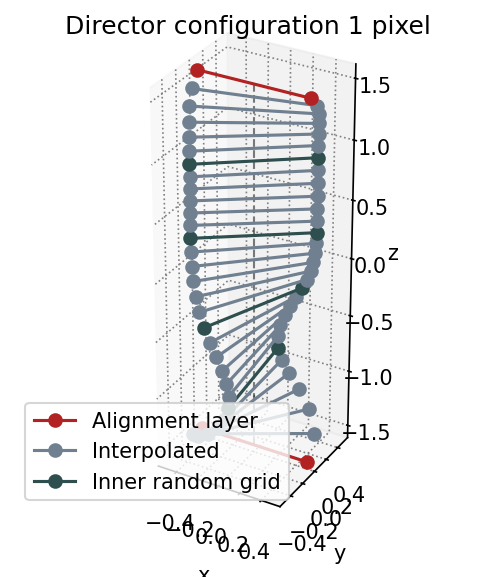

In [6]:
# EXAMPLE 1 CONFIGURATION GENERATION:
"""
Demonstration of what the randomly generated configuration looks like.
Try playing around with the parameters a bit.
"""
phi_all, theta_all, psi_all = generate_random_configuration(top_phi=0,
                                                            bottom_phi=0,
                                                            top_theta=np.pi/2,
                                                            bottom_theta=np.pi/2,
                                                            random_theta=False)

x_all, y_all, z_all = angles_to_xyz(phi_all, theta_all)
visualize_config_3D(z_layers, z_grid, x_all, y_all, z_all)

In [26]:
# DATA GENERATION:
"""
Data is generated in 2 parts.
The first part generates all of the random director configurations
based on all the given alignment layers combinations.
The other part takes care of drawing random values from uniform distribution
for intensity and dfactor and then combining all possible combinations
in the "i_d" array.

Both parts are then joined together in the "labels" array so that every configuration meets all possible dfactor and intensity combinations.
one element of labels:
phi, phi, phi, ... theta, theta, theta, ... intensity, dfactor


Images are simulated using the dtmm library, so that each label gets a
corresponding set of 18 images, each simulated under specific experimental
configuration. The sequence of 18 experimental configurations is universal.
one element of images:
a set of 18 1*1 pixel images

Data generation is designed in a way that is compatible with larger images sizes,
just change the PIXX and PIXY parameters.
"""
# Universal experiment configuration sequence settings:
polarizers_arr = [90]
analizers_arr = [90, 120, 150, 180, 210, 240]
retarders_arr = ["none", "lambda/4", "lambda"]
offaxis_arr = []
experiment_configurations = list(itertools.product(polarizers_arr, analizers_arr, retarders_arr)) # add offaxis

# Alignment layers options:
top_phi_options = [0, np.pi/2]
bottom_phi_options = [0, np.pi/2]
top_theta_options = [np.pi/2]
bottom_theta_options = [np.pi/2] 
alignment_configurations = list(itertools.product(top_phi_options, bottom_phi_options, top_theta_options, bottom_theta_options))

N_REP = 40000 # how many different random configurations to build from 1 alignment layer

# Prepare ranges for each parameter:
INTENSITY_MIN, INTENSITY_MAX = 0.7, 1.5
DFACTOR_MIN, DFACTOR_MAX = 0.5, 1
RND_SIZE = 10 # how many random points between intensity/dfactor min/max 

conf = generate_configurations(alignment_configurations, n_rep=N_REP, n_all_layers=N_ALL_LAYERS, theta=False)  
i_d = np.random.uniform(low=[INTENSITY_MIN, DFACTOR_MIN], high=[INTENSITY_MAX, DFACTOR_MAX], size=(len(conf), RND_SIZE, 2)) # each configuration gets its own i_d random array

###### Pre-generation checks #######
print(f"Labels will have shape ({len(conf)*len(i_d[0])}, {N_ALL_LAYERS*2+2}) and will take approximately {len(conf)*len(i_d[0])*(N_ALL_LAYERS*2+2)*8e-9:.2f} GB of space." )
print(f"Images will have shape ({len(conf)*len(i_d[0])}, {len(experiment_configurations)}, {PIXY}, {PIXX}, 3) and will take approximately {len(conf)*len(i_d[0])*len(experiment_configurations)*PIXY*PIXX*3*8e-9:.2f} GB of space." )
print(f"Approximate generation time: {0.00055625 * len(conf)*len(i_d[0]):.0f} minutes (={0.00055625/60 * len(conf)*len(i_d[0]):.1f} hours)")


# older i_d version:

# i_d = np.random.uniform(low=[INTENSITY_MIN, DFACTOR_MIN], high=[INTENSITY_MAX, DFACTOR_MAX], size=(RND_SIZE, 2))


###### Pre-generation checks #######
# print(f"Labels will have shape ({len(conf)*len(i_d)}, {N_ALL_LAYERS*2+2}) and will take approximately {len(conf)*len(i_d)*(N_ALL_LAYERS*2+2)*8e-9:.2f} GB of space." )
# print(f"Images will have shape ({len(conf)*len(i_d)}, {len(experiment_configurations)}, {PIXY}, {PIXX}, 3) and will take approximately {len(conf)*len(i_d)*len(experiment_configurations)*PIXY*PIXX*3*8e-9:.2f} GB of space." )
# print(f"Approximate generation time: {0.00055625 * len(conf)*len(i_d):.0f} minutes (={0.00055625/60 * len(conf)*len(i_d):.1f} hours)")

Labels will have shape (1600000, 64) and will take approximately 0.82 GB of space.
Images will have shape (1600000, 18, 1, 1, 3) and will take approximately 0.69 GB of space.
Approximate generation time: 890 minutes (=14.8 hours)


In [8]:
####### Computation #########
"""
If you are OK with estimated disk space and time consumption, start the computation.
"""

"""
Try only predicting the grid values --> in the other jupyter file
"""

# # a) build from scratch:
# labels_arr = generate_labels(conf, i_d) # 0.0009 sec, 224 kB, 256 samples
# np.save(f"{SAVEFOLDER}1pix_labels_arr_{FILENAME}.npy", labels_arr)

# images_arr = generate_images(conf, i_d) # 9 sec (10000x slower) 108 kB, 256 samples, 100% od time = calc_images
# np.save(f"{SAVEFOLDER}1pix_images_arr_{FILENAME}.npy", images_arr)


# b) load:
labels_arr = np.load(f"{SAVEFOLDER}1pix_labels_arr_{FILENAME}.npy")
images_arr = np.load(f"{SAVEFOLDER}1pix_images_arr_{FILENAME}.npy")


# shuffle and split into train and test sets(random state 42 ensures reproducible results):
x_train, x_test, y_train, y_test = train_test_split(images_arr, labels_arr, shuffle=True, test_size=0.2, random_state=42)

In [10]:
# BUILDING AND TRAINING THE NEURAL NETWORK
"""

Initialize and train the neural network.

#-------------- SECTION COPIED FROM ML_electrophoresis FILE (START) --------------------#

The actual neural network part is arguably easier to understand than
the data preparation part. At least for this specific case.

Neural network takes an input and propagates it through the whole network,
until an output comes out.
The general architecture of a NN looks like a series of layers, each layer
consisting of nodes. Each node from one layer can be (often is) connected to
all nodes from the next layer. The nodes perform a summation operation on all
their inputs and the connections have adjustable weights that multiply the signal.


Example of just one node in layer i and "height" j:

in_i-1_j-1 \                        / -- * weight i,j -> i+1, j-1 -- node i+1,j-1
            \                      /
in_i-1_j  --  node i_j (summation) ----- * weight i,j -> i+1, j   -- node i+1,j
            /                      \
in_i-1_j+1 /                        \ -- * weight i,j -> i+1, j+1 -- node i+1,j+1


There are also hidden "activation functions" (like ReLU, or tanh ...) after every node
that take the signal from the node as an argument. The output introduces non-linearity,
allowing to capture complex relations.

So, we can imagine that NN is capable of capturing certain features of the signal:
a signal with certain features will propagate through teh NN in a specific way, leading
to a certain kind of output. These features are not necessarily human-intuitive.

However, if we provide a pair of input AND the desired output, we can perform
a fitting operation, called back-propagation, where we slowly adjust all weights
in order to minimize the difference from desired output and actual output.
Because there are A LOT of weights, we need A LOT of data to achieve convergence.
Usually, we feed the same data many times, each time is called one "epoch".

There are many parameters that can be adjusted for better operation:
- NN architecture (number of elements in each layer, for example, this one is built like
                    input() - 512 - 256 - 128 - 64 - out(2))
                    (there also exist many different architecture types for different tasks)
- activation functions (e.g. sigmoids for classification, linear for regression)
- number of epochs
- validation split (percentage of data to use for validation)
- optimizer (e.g. Adam), learning rate value ...
- batch size (calculations in batches for memory efficiency)
- early stopping to avoid overfitting ...

#-------------- SECTION COPIED FROM ML_electrophoresis FILE (END) --------------------#


Even though the data generation is suitable for upgrading to more pixels, 
the neural network part is now completely different. For using it 
for more pixels I suggest using a convolutional architecture.
For example, check my first "ML_dtmm" file, where a CNN is decribed and implemented.

Since weight sharing was only used for convolution filters
(we can interpret individual pixels as images that have already passed
through a convolution filter with shared weights), it doesn't make
sense to use TimeDistributed layers here.

We are using a custom loss function, where additional 2 terms are used
(besides the usual MAE or MSE) to penalize the discontinuity and 
force discrete values of alignment layer.

We use a scheduler to activate this 2 terms only durign the later epochs,
when the configuration is more or less clearly determined.
"""

# # OPTION A: COMPUTE FROM SCRATCH
# onepixmodel = Sequential([
#     InputLayer(shape=(len(experiment_configurations), PIXY, PIXX, 3)),
#     Flatten(), # we preserve the input shape for backwards/forward compatibility but then flatten it
#     Dense(32, activation = "relu"),
#     Dense(64, activation = "relu"),
#     Dense(128, activation = "relu"),
#     Dense(256, activation = "relu"),
#     # Dense(512, activation = "relu"),
#     Dense(512, activation = "relu"),
#     Dense(256, activation = "relu"),
#     Dense(128, activation = "relu"),
#     Dense(y_train.shape[-1], activation = "relu") 
# ])

# # Create an instance of the callback
# CustomLossScheduler = CustomLossScheduler(weight1_i=0, weight2_i=0, weight1_f=0.2, weight2_f=0.0001, switch_epoch_w1=20, switch_epoch_w2=25)

# # Compile the model
# onepixmodel.compile(optimizer=Adam(learning_rate=0.001),
#                     loss=custom_loss(weight1=0, weight2=0, discrete_values=[0, np.pi/2]),
#                     metrics=["mean_absolute_error"])


# # Train the model:
# history = onepixmodel.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_test, y_test),callbacks=[CustomLossScheduler])
# np.save(f"{SAVEFOLDER}1pix_history_{FILENAME}.npy", history)

# #Save the entire model as a `.keras` zip archive.
# onepixmodel.save(f'{SAVEFOLDER}1pix_onepix_model_{FILENAME}.keras')
    

# OPTION B: LOAD
onepixmodel = tf.keras.models.load_model(f'{SAVEFOLDER}1pix_onepix_model_{FILENAME}.keras')
history = np.load(f"{SAVEFOLDER}1pix_history_{FILENAME}.npy", allow_pickle=True).item()

In [15]:
"""
Some analysis of the results.
It will work better with more data, better custom loss weight and epochs settings,
different NN architecture ...
"""
# Plot training & validation Mean Absolute Error values:
%matplotlib inline

plt.figure(figsize=(4,4))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(4,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# COMPARISON LABELS VS PREDICTION
y_pred = onepixmodel.predict(x_test) # run the prediction on test data sample

# plot distributions of relative errors in predicted intensity and dfactor 
plt.figure(figsize=(4,4))
plt.hist((y_pred[:,-1]-y_test[:,-1]) / y_test[:,-1] , bins=50)
plt.title("dfactor relative error")
plt.show()
plt.figure(figsize=(4,4))
plt.hist((y_pred[:,-2]-y_test[:,-2]) / y_test[:,-2], bins=50)
plt.title("intensity relative error")
plt.show()

# for saving images larger than screensize use a different backend for matplotlib:
#matplotlib.use('Agg')

# COMPARISON OF PREDICTED VS TEST PHI AND THETA ARRAYS (3D + plots)
n_pairs=5
indices = np.random.choice(np.arange(len(y_pred)), n_pairs)
fig, axs = plt.subplots(n_pairs, 3, subplot_kw={'projection': '3d'}, figsize=(10, 3.5*n_pairs), constrained_layout=True)

for n, index in enumerate(indices):
    axs[n, 0].set_box_aspect([1,1,3])
    axs[n, 1].set_box_aspect([1,1,3])
    
    #labels:
    phi_out_test = y_test[index] [:N_ALL_LAYERS]
    theta_out_test = y_test[index] [N_ALL_LAYERS : 2 * N_ALL_LAYERS]
    x_all_test, y_all_test, z_all_test = angles_to_xyz(phi_out_test, theta_out_test)
    visualize_config_3D(z_layers, z_grid, x_all_test, y_all_test, z_all_test, fig, axs[n,1], title=f"label ind {index}")
    
    #pred:
    phi_out = y_pred[index] [:N_ALL_LAYERS]
    theta_out = y_pred[index][N_ALL_LAYERS : 2 * N_ALL_LAYERS]
    x_all_pred, y_all_pred, z_all_pred = angles_to_xyz(phi_out, theta_out)
    visualize_config_3D(z_layers, z_grid, x_all_pred, y_all_pred, z_all_pred, fig, axs[n,0], title=f"predicted ind {index}")
    
    # Create new axes within the third column using GridSpec
    gs = axs[n, 2].get_gridspec()
    
    # Remove the original axs[i, 2] to make room for the new layout
    for ax in axs[n, 2:]:
        ax.remove()
    
    # Define the new GridSpec layout for the third column (2 rows, 1 column)
    ax3_top = fig.add_subplot(gs[n, 2].subgridspec(2, 1, height_ratios=[1, 1])[0])
    ax3_bottom = fig.add_subplot(gs[n, 2].subgridspec(2, 1, height_ratios=[1, 1])[1])

    # Plot in the top subplot of the third column
    ax3_top.plot(np.arange(len(phi_out_test)), phi_out_test, label="label")
    ax3_top.plot(np.arange(len(phi_out_test)), phi_out, label="pred")
    ax3_top.plot(np.arange(len(phi_out_test)), phi_out_test-phi_out, label="diff")
    ax3_top.set_xticklabels([])
    ax3_top.set_ylabel("phi")
    ax3_top.legend()

    # Plot in the bottom subplot of the third column
    ax3_bottom.plot(np.arange(len(theta_out_test)), theta_out_test, label="label")
    ax3_bottom.plot(np.arange(len(theta_out_test)), theta_out, label="pred")
    ax3_bottom.plot(np.arange(len(theta_out_test)), theta_out_test - theta_out, label="diff")
    ax3_bottom.set_ylabel("theta")
    ax3_bottom.legend()
    
    
plt.tight_layout()
#fig.savefig("theta_examples.png",bbox_inches='tight')

   46/10000 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step  

C:\Users\PolarBear2017\AppData\Local\Temp\ipykernel_6896\1003492578.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\PolarBear2017\AppData\Local\Temp\ipykernel_6896\1003492578.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 10s 949us/step


C:\Users\PolarBear2017\AppData\Local\Temp\ipykernel_6896\1003492578.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\PolarBear2017\AppData\Local\Temp\ipykernel_6896\1003492578.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\PolarBear2017\AppData\Local\Temp\ipykernel_6896\1003492578.py:93: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


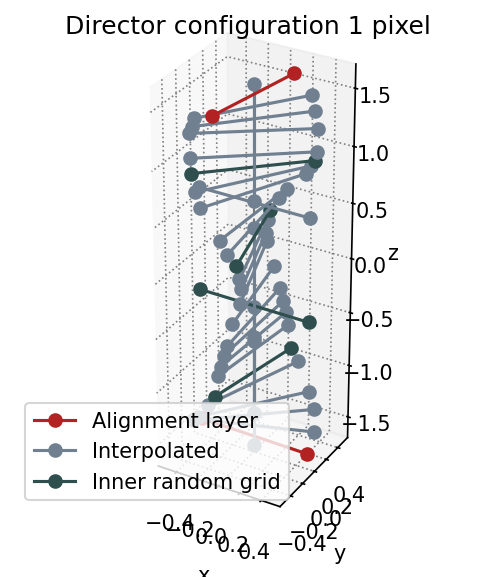

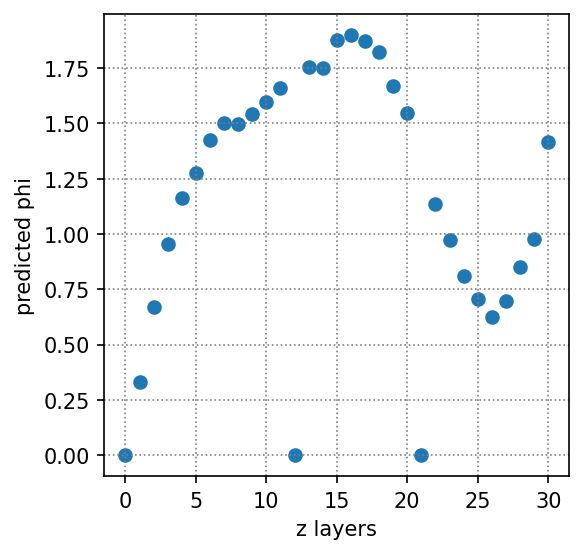

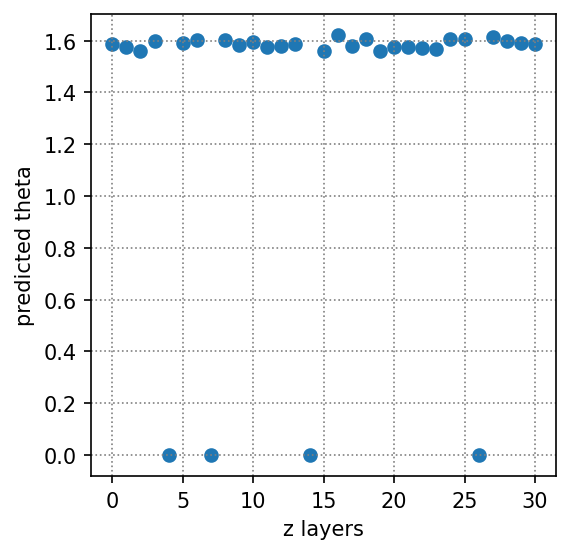

In [51]:
# EXAMPLE WITH EXPERIMENTAL DATA:
"""
print(experiment_configurations):

[(90, 90, 'none'), (90, 90, 'lambda/4'), (90, 90, 'lambda'),
(90, 120, 'none'), (90, 120, 'lambda/4'), (90, 120, 'lambda'),
(90, 150, 'none'), (90, 150, 'lambda/4'), (90, 150, 'lambda'),
(90, 180, 'none'), (90, 180, 'lambda/4'), (90, 180, 'lambda'),
(90, 210, 'none'), (90, 210, 'lambda/4'), (90, 210, 'lambda'),
(90, 240, 'none'), (90, 240, 'lambda/4'), (90, 240, 'lambda')]

Shape of 1 input element: (18, 1, 1, 3) = (len(experimental_configurations), PIXY, PIXX, 3(RGB))

Be careful: "predict" function takes a whole array of input samples
(such as "[[input for example 1], [input for example 2], [input for example 3] ...]")
and returns a whole array of output labels as well,
(such as "[[output for example 1], [output for example 2], [output for example 3] ...]")

If we only have ONE sample (but still all 18 images of course), make sure to introduce another
dimesion for input ( [input for example 1] -> [[input for example 1]] )
and to only look at the the first element of the output (y_pred[0] and not y_pred),
as demonstrated below.

"onepixmodel" is a NN object with all the weights already determined.
It is either loaded or computed in the pre-previous cell.
"""

# What you would get from an experiment:
x_example=np.array(
                    [[[[0.97508677, 0.35158799, 0.11277321]]], # RGB values for exp config = (90, 90, 'none')
                     [[[0.69459894, 0.61641281, 0.15548417]]], # RGB values for exp config = (90, 90, 'lambda/4')
                     [[[0.97547249, 0.28730787, 0.17302808]]],
                     [[[0.72763683, 0.37400661, 0.19401243]]],
                     [[[0.52345509, 0.52067548, 0.20800506]]],
                     [[[0.72792015, 0.34616767, 0.2146864 ]]],
                     [[[0.37517569, 0.55644126, 0.33445807]]],
                     [[[0.64066615, 0.42589512, 0.32656898]]],
                     [[[0.37451995, 0.57233904, 0.32249948]]],
                     [[[0.48430663, 0.67321201, 0.39951704]]],
                     [[[0.85631935, 0.45432346, 0.38673656]]],
                     [[[0.48335082, 0.69796927, 0.38008556]]],
                     [[[0.82987185, 0.66280837, 0.37090328]]],
                     [[[0.95826114, 0.56437182, 0.36396227]]],
                     [[[0.82963316, 0.67558136, 0.36039743]]],
                     [[[1.        , 0.52929232, 0.25567184]]],
                     [[[0.89419268, 0.63462586, 0.26609825]]],
                     [[[1.        , 0.51167094, 0.27118454]]]]) # RGB values for exp config = (90, 240, 'lambda')


# make a prediction using an existing model: 
y_pred_example = onepixmodel.predict(np.array([x_example]))[0] # "np.array([])" and [0] because of requested shape for "predict()"

# extract phi array, theta array, intensity, dfactor from predicted label:
y_pred_example_phi_array = y_pred_example[: N_ALL_LAYERS]
y_pred_example_theta_array = y_pred_example[N_ALL_LAYERS : 2*N_ALL_LAYERS]
y_pred_example_intensity = y_pred_example[-2]
y_pred_example_dfactor = y_pred_example[-1]

# convert to (x, y, z) and visualize 3D:
x_all_pred_example, y_all_pred_example, z_all_pred_example = angles_to_xyz(y_pred_example_phi_array, y_pred_example_theta_array)
visualize_config_3D(z_layers, z_grid, x_all_pred_example, y_all_pred_example, z_all_pred_example)

# plot phi(z):
plt.figure(figsize=(4,4))
plt.scatter(np.arange(len(y_pred_example_phi_array)), y_pred_example_phi_array)
plt.xlabel("z layers")
plt.ylabel("predicted phi")
plt.show()

# plot theta(z):
plt.figure(figsize=(4,4))
plt.scatter(np.arange(len(y_pred_example_theta_array)), y_pred_example_theta_array)
plt.xlabel("z layers")
plt.ylabel("predicted theta")
plt.show()

In [33]:
# DTMM NOT SURE IF NECESSARY FOR FUTURE?

# SHAPE = (60,16,16) # data shape (n layers, n pixels height, n pixels width)
# which polarization states of input light we compute for.

# POLARIZATIONS = [(0,1),(1,0)]
# # wavelength used for single-wavelength calculation
# WAVELENGTH = 785
# # intensity used for single-wavelength calculation
# INTENSITY = 1e6
# # wave propagation parameter for single-wavelength calculation
# BETA = 0 # see dtmm documentation on this, the beta parameter n*sin(theta)
# # The phi angle of the wave, only matters if BETA != 0
# PHI = 0 

# wavelength range for the multi-wavelength calculation
WAVELENGTHS = np.linspace(380,780,11) # nm
# # wave intensity for each of the waves of the multi-wavelength calculation.
# INTENSITIES = [INTENSITY]*len(WAVELENGTHS)

# # wave beta parameter for each of the waves of the multi-wavelength calculation.
# BETAS = [BETA]*len(WAVELENGTHS) 

# # wave phi parameter for each of the waves of the multi-wavelength calculation.
# PHIS = [PHI]*len(WAVELENGTHS) 

# sample thickness
# THICKNESS = 3.1 # microns
# # imaged region 
# WIDTH = 40. # microns
# HEIGHT = 40. # microns

# # cover/substrate glass refractive index
# NCOVER = 1.5

# # STOP! Computed constants, Do not set manually!
# ########################################################################
# STEPSIZE = THICKNESS/SHAPE[0]*1000 #nm
# # unitless wave number of fundamental and shg waves. Do not set manually!
# K0 = 2*np.pi/WAVELENGTH * STEPSIZE
# K0S = 2*np.pi/WAVELENGTHS * STEPSIZE

# # epsilon and euler angles for the cover glass
# EPSILON0 = np.ones((3,)) * NCOVER **2
# ANGLES0 = np.zeros((3,)) 

# # matrices size in MB for single-wavelength run
# MB_WAVELENGTH = 2* SHAPE[0]*SHAPE[1]*SHAPE[2]*4*4/1024/1024 * np.dtype(CDTYPE).itemsize 
# # matrices size in MB for single-pixel run
# MB_PIXEL = 2* len(WAVELENGTHS) * SHAPE[0]*4*4/1024/1024 * np.dtype(CDTYPE).itemsize 
# # required memroy size for full computation
# GB_FULL = 2*len(WAVELENGTHS)* SHAPE[0]*SHAPE[1]*SHAPE[2]*4*4/1024/1024/1024 * np.dtype(CDTYPE).itemsize 

# # matrices size in MB for single-wavelength run
# MB_WAVELENGTH_F = len(POLARIZATIONS)*MB_WAVELENGTH//SHAPE[0]
# # matrices size in MB for single-pixel run
# MB_PIXEL_F = len(POLARIZATIONS)*MB_PIXEL//SHAPE[0]
# # required memroy size for full computation
# GB_FULL_F = len(POLARIZATIONS)*GB_FULL//SHAPE[0]